In [6]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import collections
import sparse

FUNCTIONs:

Les fonctons suivantes, sont les bases de la calibration de la caméra, ils permettent de trouver les matrices, 1 des parametres intrinsèques de la caméra. 2, la matrice de transformation, entre deux images,résolvant une équation de projection

In [7]:
def get_camera_matrix(images):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((5*5,3), np.float32)
    objp[:,:2] = np.mgrid[0:5,0:5].T.reshape(-1,2)
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (5,5),None)
        if ret == True:
            objpoints.append(objp)

            corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
            imgpoints.append(corners2)
        
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    #print(rvecs, tvecs)
    return mtx, dist,imgpoints
    

In [ ]:
def trans_matrix(r,t):
    # T (ki to t), rotate and transport matrix
    (a,b,c) = (r[0][0], r[1][0], r[2][0])
    (x,y,z) = (t[0][0],t[1][0],t[2][0])
    Rz = np.matrix([[1,0,0],
          [0, np.cos(a), -np.sin(a)],
         [0, np.sin(a), np.cos(a)]])
    Ry = np.matrix([[np.cos(b), 0 , np.sin(b)],
          [0 , 1, 0],
          [-np.sin(b), 0 , np.cos(b)]])
    Rx = np.matrix([[np.cos(c), -np.sin(c), 0],
         [np.sin(c), np.cos(c), 0],
         [0,0,1]])
    R = np.dot(Rz,np.dot(Ry,Rx))
    T = np.concatenate((R, np.matrix([[x],[y],[z]])), axis=1)
    
    return T

In [3]:
def transpose_matrix(fname, mtx, dist):  
    objp = np.zeros((5*5,3), np.float32)
    objp[:,:2] = np.mgrid[0:5,0:5].T.reshape(-1,2)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (5,5),None)
    if ret == True:
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        # Find the rotation and translation vectors.
        _, rvecs, tvecs, inliers = cv2.solvePnPRansac(objp, corners2, mtx, dist)
    else:
        return False
    T = trans_matrix(rvecs, tvecs)
    
    return T

Avec les Informations, récupérer en utilisant les fonctions ci dessus nous sommes maintenant en mesure de recréer un fichier .ply, contenant l'ensemble des informations, pour la représentation de la carte dans l'espace. Cette fonction, vert, prend en entrée l'image, initiale, la carte de profondeur, associé, la matrice de transformation du temps 1 au temps 2 et la matrice des paramètres intrinsèques de la caméra.
Elle applique la formule présentéer dans le CNN-SLAM: V_ki(u)=(K^-1)*u(homogene)*D(u) ou D est la carte de prof.

In [ ]:
def vert(img,D, T,K, inv = True):
    l = img.shape[0]
    h = img.shape[1]
    t = 0
    temp = np.zeros((l*h, 6))
    T = np.concatenate((T, np.array([[0,0,0,1]])), axis=0)
    if inv:
        T = np.linalg.inv(T)
    K = np.eye(3)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if 10 < D[i,j]< 200:
                u = np.array([i,j, D[i,j], 1])
                aa = np.dot(T, u)
                x = np.zeros(3)
                x[0:3] = aa[0:3]/aa[3]
                x = np.dot(K, x)
            
                temp[t,0] = x[0]
                temp[t,1] = x[1]
                temp[t,2] = x[2]
                temp[t,3:6] = img[i,j]
                t = t+1
    return temp

La fonction Suivante permet de recréer, à partir de la library sparse, notre représentation, la comparaison des résultats, fut "assez concluante".

In [ ]:
def get_spm(res):
    n = 2000
    ndims = 3
    coords = 1000 + np.floor(res[:,0:3].T)
    datar = res[:,3].T
    datag = res[:,4].T
    datab = res[:,5].T

    r = sparse.COO(coords, datar, shape=((n,) * ndims))
    g = sparse.COO(coords, datag, shape=((n,) * ndims))
    b = sparse.COO(coords, datab, shape=((n,) * ndims))
    return coords,r,g,b

Après avoir, essayé de rajouter nos données l'une à l'autre, de manière triviale, on essaie de combiner de manière plus intelligente les deux fichiers que nous avons. Nous utilisons les représentations, éparses. On utilse les coordonnées et l'on essaie de créer une couleur, moyenne pour l'ensemble de points. Ceci ayant pour but de ne pas avoir des sauts de couleurs, sur une meme surface. Le résultats n'est pas concluant. On crée notre tableau, qui va nous permettre d'écrire le fichier .ply. Ceci est caractérisé par get_res.

In [ ]:
def combine(res1, res2):
    c1, r1, g1, b1 = get_spm(res1)
    c2, r2, g2, b2 = get_spm(res2)
    for i in range(c1.shape[1]):
        
    
    r = (r1+r2)/2
    g = (g1+g2)/2
    b = (b1+b2)/2
    bbb = r.coords
    
    
    return bbb,r, g, b

In [ ]:
def get_res(c, r, g, b):
    l = c.shape[1]
    temp = np.zeros((l, 6))

    for i in range(l):
        temp[i,0] = c[0,i] - 1000
        temp[i,1] = c[1,i] -1000
        temp[i,2] = c[2,i]-1000
        
        temp[i,3] = r[c[0,i],c[1,i],c[2,i]]
        temp[i,4] = g[c[0,i],c[1,i],c[2,i]]
        temp[i,5] = b[c[0,i],c[1,i],c[2,i]]
               
    return temp

Cette fonction nous permet d'écrire un fichier ply

In [ ]:
ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar blue
property uchar green
end_header
'''
def write_ply(fn,verts ):
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d')

La fonction suivante, a été créée dans le butd'utiliser les  descripteurs, (SIFT, SURF ou ORB), pour trouver notre matrice de transformations, entre les temps 1 et 2. Elle prend en entrée des coordonnées de points sorties par le détecteur, et renvoie la valeur associée au pixel définie par les coordonnée  de la profondeur, issue de la carte de profondeur

In [2]:
def verttt(pts,D):
    res = np.zeros((1,len(pts) ,3),dtype = np.int8)
    for i in range(len(pts)):
        res[0][i][0] = int(pts[i][1]/8)
        res[0][i][1] = int(pts[i][0]/8)
        res[0][i][2] = D[res[0][i][0],res[0][i][1]]
    
    return resdef 

On rentre dans les fonctions qui vont nous permettre de créer la carte d'incertitude. Ceci est basé encore une fois sur l'article CNN-SLAM. La première fonction n'a pour but que de passer du point 3D à un pixel 2D. On prends la prédiction de profondeur de deux images. Puis l'on utilise la transformation ayant eu lieu entre l'image 1 et l'image 2 et l'on a sorti (théoriquement) par estimeAffine3D. Ensuite on applique pixel par pixel la fonction uncertainty_fcn   

In [ ]:
def pi_fcn(x):
    u = np.zeros((2,1), dtype = np.int8)

    u[0] = int(x[0])
    u[1] = int(x[1])
    return u

In [ ]:
def uncertainty_fcn(K,T,x,D1,D2):
    t_x = np.zeros((4,1))
    t_x[0] = x[0]
    t_x[1] = x[1]
    t_x[2] = D1[x[0],x[1]]
    t_x[3] = 1
    l = D1.shape[0]
    h = D1.shape[1]
    
    
    temp = np.dot(T,t_x)
    temp = np.dot(K,temp)
    temp = pi_fcn(temp)
    #print( temp[0],temp[1],l,h)
    if 0<=temp[0]<l and 0<=temp[1]<h:
        depth = D2[temp[0],temp[1]]
        #print('hah')
    else :
        depth = t_x[2]
    return np.square((t_x[2]- depth))

In [ ]:
def uncertainty_matrix(K,T,D1,D2):
    l = D1.shape[0]
    h = D1.shape[1]
    res = np.zeros((l,h))
    for i in range(l):
        for j in range(h):
            x = np.array((i,j))
            res[i,j] = uncertainty_fcn(K,T,x,D1,D2)
    return res

Toujours baser sur le même article, on code l carte d'incertitude de propagation. Elle se base sur la carte de profondeur des deux images, puis la carte d'incertitude calculée précédemment. Son rôle n'est pas encore très claire, dans le Rafinement de la prédiction de profondeur.

In [ ]:
def prog_fcn(K,T,x,Di,Dj,U):
    t_x = np.zeros((4,1))
    t_x[0] = x[0]
    t_x[1] = x[1]
    t_x[2] = Di[x[0],x[1]]
    t_x[3] = 1
    l = Di.shape[0]
    h = Di.shape[1]
    
    
    temp = np.dot(T,t_x)
    temp = np.dot(K,temp)
    temp = pi_fcn(temp)
    #print( temp[0],temp[1],l,h)
    if 0<=temp[0]<l and 0<=temp[1]<h:
        depth = Dj[temp[0],temp[1]]
        #print('hah')
    else :
        depth = t_x[2] 

    uu = U[temp[0], temp[1]]
    pp = 0
    #print(uu*(depth/t_x[2]))
    
    return temp[0], temp[1], uu*(depth/t_x[2]) + pp

In [ ]:
def prog_matrix(K,T,Di,Dj,U):
    l = Di.shape[0]
    h = Di.shape[1]
    res = np.zeros((l,h))
    for i in range(l):
        for j in range(h):
            x = np.array((i,j))
            a, b, temp = prog_fcn(K,T,x,Di,Dj,U)
            if 0<=a<l and 0<=b<h:
                res[a,b] = temp
    return res

Tentative de rafinement de la carte de profondeur, avec laide des deux cartes calculées juste avant. Les formules sont décrites dans l'article CNN-SLAM

In [ ]:
def refine_fcn(K,T,x,Di,Dj,U_i,U_jj):
    t_x = np.zeros((4,1))
    t_x[0] = x[0]
    t_x[1] = x[1]
    t_x[2] = Di[x[0],x[1]]
    t_x[3] = 1
    l = Di.shape[0]
    h = Di.shape[1]
    
    #x : u,  temp: v
    #
    temp = np.dot(T,t_x)
    temp = np.dot(K,temp)
    temp = pi_fcn(temp)
    #print( temp[0],temp[1],l,h)
    if 0<=temp[0]<l and 0<=temp[1]<h:
        depth = Dj[temp[0],temp[1]]
        Drefine = U_jj[temp[0],temp[1]]*t_x[2] + U_i[x[0],x[1]]*Dj[temp[0],temp[1]]
        Drefine = Drefine/(U_i[x[0],x[1]]+U_jj[temp[0],temp[1]])
        
        Urefine = U_jj[temp[0],temp[1]]*U_i[x[0],x[1]]/(U_jj[temp[0],temp[1]]+U_i[x[0],x[1]])
    else :
        Drefine = Di[x[0],x[1]]
        Urefine = 0
    
    
    return Drefine, Urefine

In [ ]:
def refine_matrix(K,T,Di,Dj):
    l = Di.shape[0]
    h = Di.shape[1]
    res_d = np.zeros((l,h))
    res_u = np.zeros((l,h))
    U_i = uncertainty_matrix(K,T,Di,Dj)
    U_jj = prog_matrix(K,T,Di,Dj,U_i)
    for i in range(l):
        for j in range(h):
            x = np.array((i,j))
            res_d[i,j], res_u[i,j] = refine_fcn(K,T,x,Di,Dj,U_i,U_jj)
    return res_d, res_u

FIN FONCTIONS.

Chargement des images:

In [4]:
images = glob.glob('cv/*.jpg')
mtx, dist, imgpoints = get_camera_matrix(images)

In [6]:
fname = 'cv/c3.jpg'
T3 = transpose_matrix(fname,mtx, dist)
fname = 'cv/c2.jpg'
T2 = transpose_matrix(fname,mtx, dist)
fname = 'cv/c1.jpg'
T1 = transpose_matrix(fname,mtx, dist)

In [7]:
fname0 = 'cv/cd1.jpg'
img1 = cv2.imread(fname0)
fname1 = 'cv/cd2.jpg'
img2 = cv2.imread(fname1)
fname2 = 'cv/cd3.jpg'
img3 = cv2.imread(fname2)

img10 = cv2.imread('cv/c1.jpg')
img10 = cv2.resize(img10, (160, 128))
img20 = cv2.imread('cv/c2.jpg')
img20 = cv2.resize(img20, (160, 128))
img30 = cv2.imread('cv/c3.jpg')
img30 = cv2.resize(img30, (160, 128))


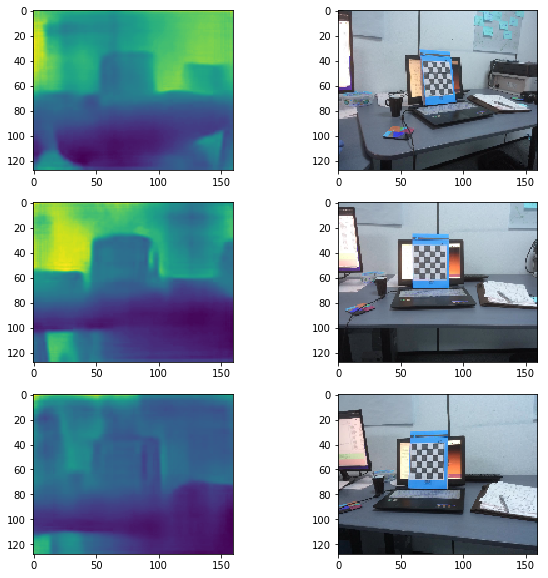

In [9]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.figure(1)
plt.subplot(321)
plt.imshow(img1[:,:,1])

plt.subplot(322)
plt.imshow(img10)

plt.subplot(323)
plt.imshow(img2[:,:,1])

plt.subplot(324)
plt.imshow(img20)

plt.subplot(325)
plt.imshow(img3[:,:,1])

plt.subplot(326)
plt.imshow(img30)
plt.show()

In [132]:
res1 = vert(img10, img1[:,:,1], T1, mtx)
res2 = vert(img20, img2[:,:,1], T2, mtx)
res3 = vert(img30, img3[:,:,1], T3, mtx)
res = np.concatenate((res1,res2,res3), axis=0)
res.shape

(61440, 6)

## Try to Delete Some Points


Si point unique, nous le prenons , sinon on l'associe a celui retrouve

In [53]:
records_array = np.array([1, 2, 3, 1, 1, 3, 4, 4, 3, 2])
idx_sort = np.argsort(records_array)
sorted_records_array = records_array[idx_sort]
vals, idx_start, count = np.unique(sorted_records_array, return_counts=True,
                                return_index=True)

# sets of indices
res = np.split(idx_sort, idx_start[1:])
#filter them with respect to their size, keeping only items occurring more than once

vals = vals[count > 1]
res = filter(lambda x: x.size > 1, res)

In [102]:
l=((np.size(x))*95)/100
idx_sort[1: l]
cc[:,l]

In [152]:
cc.shape[1]

57460

In [146]:
cc, rr, gg, bb= combine(res1,res2)
res00 = get_res(cc, rr, gg, bb)

In [148]:
cc, rr, gg, bb= combine(res00,res3)
res00 = get_res(cc, rr, gg, bb)

In [149]:
write_ply('out2.ply', res00)
print('%s saved' % 'out1.ply')

out1.ply saved


## write the 3d model

In [113]:

write_ply('out2.ply', res00)
print('%s saved' % 'out1.ply')


out1.ply saved


## ORB: Test Detector


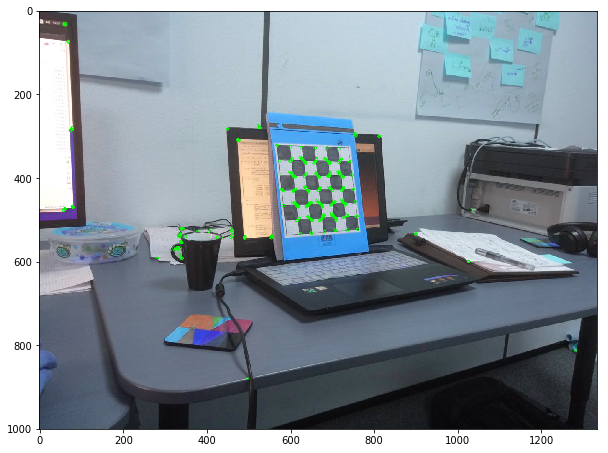

(<matplotlib.image.AxesImage at 0x21c50db59e8>, None)

In [157]:
img = cv2.imread('cv/c1.jpg')
# Initiate ORB detector
orb = cv2.ORB_create()
# find the keypoints with ORB
kp = orb.detect(img,None)
# compute the descriptors with ORB
kp, des = orb.compute(img, kp)
# draw only keypoints location,not size and orientation
img2 = cv2.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2), plt.show()

## get transport matrix from SURF

L'idée: Utiliser les descripteurs, pour obtenir des points remarquables, permettant de sortir la matrice de transformation, permettant de faire matcher les différentes représentations obtenues par vert


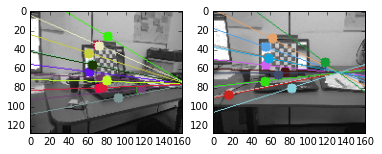

In [13]:
img10 = cv2.imread('cv/c1.jpg')
img10 = cv2.resize(img10, (160, 128))
img11 = img10[:,:,0]
img20 = cv2.imread('cv/c2.jpg')
img20 = cv2.resize(img20, (160, 128))
img21 = img20[:,:,0]
surf = cv2.xfeatures2d.SURF_create()



# find the keypoints and descriptors with SIFT
kp1, des1 = surf.detectAndCompute(img11,None)
kp2, des2 = surf.detectAndCompute(img21,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]


def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2


# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img11,img21,lines1,pts1,pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img21,img11,lines2,pts2,pts1)

plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

In [14]:
pts1.shape

(14, 2)

On récupère dans pts1 et pts2 les coordonnées des points ayant matché d'une image à l'autre, ensuite on utilise la fonction, estimeaffine3D, pour en sortir , la matrice de transformation. De plus, la fonction verttt, permet de passer d'une suite de coordonnées 2D à une coordonnée 3D

In [20]:
pts11 = verttt(pts1,img1[:,:,1] )
pts21 = verttt(pts2,img2[:,:,1] )

NameError: name 'img1' is not defined

In [18]:
retval, M, inliers = cv2.estimateAffine3D(pts11, pts21)
M

NameError: name 'pts11' is not defined

M est la matrice de transformation, entre l'image 1, dont les points détectés sont dans pts1 et l'image2 dont les points détectés sont dans l'image 2


In [3]:
img10 = cv2.imread('cv/c1.jpg')
img10 = cv2.resize(img10, (160, 128))
img20 = cv2.imread('cv/c2.jpg')
img20 = cv2.resize(img20, (160, 128))

T_eye = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])
res1 = vert(img10, img1[:,:,1], M, mtx,inv = False)
res2 = vert(img20, img2[:,:,1], T_eye, mtx)
res = np.concatenate((res1,res2), axis=0)
res.shape

NameError: name 'cv2' is not defined

2D, meme idée en utilisant la fonction findHomography qui trouve, la projection, entre le plan départ et celui d'arrivée, en se basant sur l'évolution des détecteurs dans lesdeux images

In [69]:
img2 = cv2.imread('cv/cd2.jpg')
img2.shape

(128, 160, 3)

In [12]:
img = cv2.imread('cv/cd1.jpg')
img = cv2.resize(img,(1334,1000))
img2 = cv2.imread('cv/cd2.jpg')
img2 = cv2.resize(img2,(1334,1000))

src_pts = np.float32(pts1).reshape(-1,1,2)
dst_pts = np.float32(pts2).reshape(-1,1,2)
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
dst = cv2.warpPerspective(img,M,(1334,1000))


NameError: name 'pts1' is not defined

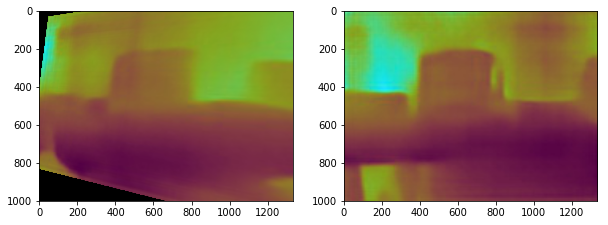

In [65]:
#plt.rcParams['figure.figsize'] = [10, 10]
plt.figure(1)
plt.subplot(121)
plt.imshow(dst)

plt.subplot(122)
plt.imshow(img2)

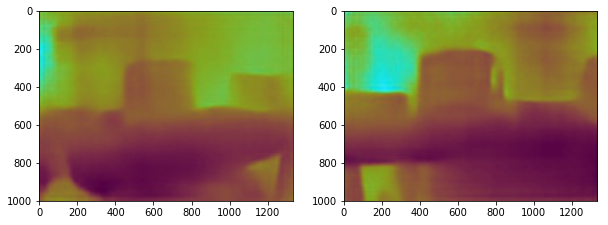

In [67]:
plt.figure(1)
plt.subplot(121)
plt.imshow(img)

plt.subplot(122)
plt.imshow(img2)

Uncertainty map, Donc l'idée, est "d'évaluer" la prédiction de profondeur, que l'on a obtenu, en y associant une valeur d'incertitude.

In [11]:
K = np.eye(3)
T = M
fname0 = 'cv/cd1.jpg'
img1 = cv2.imread(fname0)
fname1 = 'cv/cd2.jpg'
img2 = cv2.imread(fname1)

ttt = uncertainty_matrix(K,T,img1[:,:,1],img2[:,:,1])

NameError: name 'M' is not defined

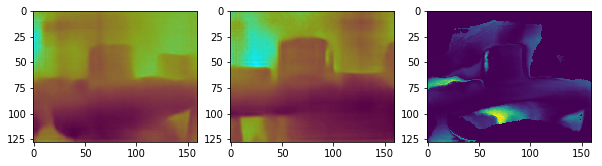

In [231]:
plt.rcParams['figure.figsize'] = [10, 10]

plt.figure(1)
plt.subplot(131)
plt.imshow(img1)

plt.subplot(132)
plt.imshow(img2)

plt.subplot(133)
plt.imshow(ttt)

## propagation

In [240]:
K = np.eye(3)
T = M
fname0 = 'cv/cd1.jpg'
img1 = cv2.imread(fname0)
fname1 = 'cv/cd2.jpg'
img2 = cv2.imread(fname1)
fname2 = 'cv/cd3.jpg'
img3 = cv2.imread(fname2)

t1 = uncertainty_matrix(K,T,img1[:,:,1],img2[:,:,1])
ttt = prog_matrix(K,T,img1[:,:,1],img2[:,:,1],t1)

E:\program\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


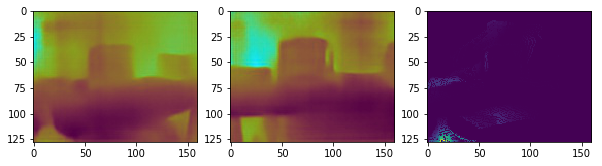

In [243]:
plt.rcParams['figure.figsize'] = [10, 10]

plt.figure(1)
plt.subplot(131)
plt.imshow(img1)

plt.subplot(132)
plt.imshow(img2)

plt.subplot(133)
plt.imshow(ttt)

## refinement

In [18]:
K = np.eye(3)
T = M
fname0 = 'cv/cd1.jpg'
img1 = cv2.imread(fname0)
fname1 = 'cv/cd2.jpg'
img2 = cv2.imread(fname1)
fname2 = 'cv/cd3.jpg'
img3 = cv2.imread(fname2)

ttt1, ttt2 = refine_matrix(K,T,img1[:,:,1],img2[:,:,1])

NameError: name 'M' is not defined

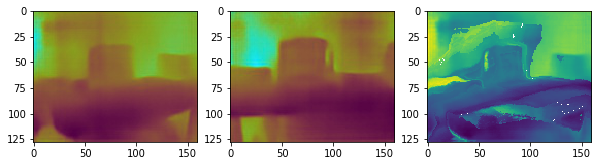

In [259]:
plt.rcParams['figure.figsize'] = [10, 10]

plt.figure(1)
plt.subplot(131)
plt.imshow(img1)

plt.subplot(132)
plt.imshow(img2)

plt.subplot(133)
plt.imshow(ttt1)

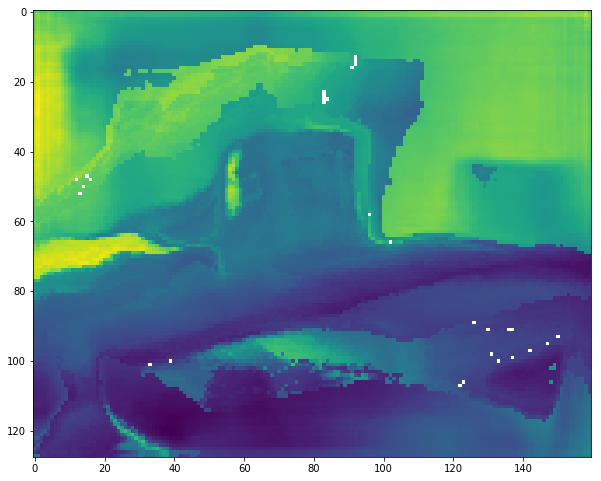

In [261]:
plt.imshow(ttt1)

In [262]:
ttt1.shape

(128, 160)

In [270]:
img10 = cv2.imread('cv/c1.jpg')
img10 = cv2.resize(img10, (160, 128))
img20 = cv2.imread('cv/c2.jpg')
img20 = cv2.resize(img20, (160, 128))

T_eye = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])
res1 = vert(img10, ttt1, T_eye, mtx,inv = False)
res2 = vert(img10, img1[:,:,1], T_eye, mtx,inv = False)

In [271]:

write_ply('out3.ply', res2)
print('%s saved' % 'out1.ply')

out1.ply saved


On va tenter avec le laplacien

(<matplotlib.text.Text at 0x7f53663f28>,
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

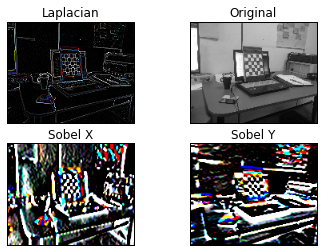

In [8]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img10 = cv2.imread('cv/c1.jpg')
img10=cv2.resize(img10, (160,128))

laplacian = cv2.Laplacian(img10,cv2.CV_8U)


plt.subplot(2,2,1),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])


plt.subplot(2,2,2),plt.imshow(img10[:,:,0],cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])

sobelx = cv2.Sobel(img10,cv2.CV_8U,1,0,ksize=5)
sobely = cv2.Sobel(img10,cv2.CV_8U,0,1,ksize=5)


plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])